# Capstone Project Part 3: Topic Modeling and Clustering

**Author:** Soohyun Ahn <br>
    
**Date:** March - April 2023<br>
    
**Notebook Number:** 3/ 4

### Important Note:

This notebook contains interactive visualizations created by PyLDAvis, which cannot be displayed here. To fully interact with them, please use `Jupyter Notebook Viewer`. Click **[here](https://nbviewer.org/github/treelunar/2023_Capstone_BSTN/blob/main/Part_3_Topic_Modeling_Clustering.ipynb)** to access the viewer.

In this notebook, we explore an unsupervised machine learning approach to analyze and cluster a dataset of movies based on their genres and latent topics. 

We begin by employing `Latent Dirichlet Allocation` (LDA) for topic modeling, which allows us to identify the underlying topics within movie descriptions. Here, the assumption is that documents are generated from a mixture of topics, and each topic is represented by a distribution over words.

Next, Based on the LDA analysis, we will measure topic probabilities using K-means and `DBSCAN`. These techniques can help us find the right number of clustering that can properly sort movies into manageable clusters.

Finally, we group the movies by their cluster labels to reveal patterns and relationships within the dataset. This comprehensive analysis aims to provide valuable insights into the structure and organization of movies based on their genres and thematic content.

## Dataset Inspection

In [1]:
# Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import gensim
import pyLDAvis.gensim_models

# Set the random seed

random.seed(42)
np.random.seed(42)
# hide warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import dataset

movies_40000_df = pd.read_csv("ada_embeddings_movie_40000.csv")
movies_40000_df.head()

,imdb_id,title,original_title,overview,clean_overview,genres,tagline,poster_path,num_tokens,ada_embeddings
0,tt0114709,Toy Story,Toy Story,"Led by Woody, Andy's toys live happily in his ...",led woodi toy live happili room birthday bring...,"['Animation', 'Comedy', 'Family']",NaN,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,26,"[-0.01801527477800846, -0.02206587977707386, 0..."
1,tt0113497,Jumanji,Jumanji,When siblings Judy and Peter discover an encha...,sibl discov enchant board game open door magic...,"['Adventure', 'Fantasy', 'Family']",Roll the dice and unleash the excitement!,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,33,"[-0.005219690967351198, -0.019913190975785255,..."
2,tt0113228,Grumpier Old Men,Grumpier Old Men,A family wedding reignites the ancient feud be...,famili wed reignit ancient feud next door neig...,"['Romance', 'Comedy']",Still Yelling. Still Fighting. Still Ready for...,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,31,"[0.006672864779829979, -0.010083439759910107, ..."
3,tt0114885,Waiting to Exhale,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",cheat mistreat step women hold breath wait elu...,"['Comedy', 'Drama', 'Romance']",Friends are the people who let you be yourself...,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,24,"[-0.016164006665349007, -0.0014150608330965042..."
4,tt0113041,Father of the Bride Part II,Father of the Bride Part II,Just when George Banks has recovered from his ...,recov daughter wed receiv news pregnant wife e...,['Comedy'],Just When His World Is Back To Normal... He's ...,/e64sOI48hQXyru7naBFyssKFxVd.jpg,17,"[-0.012427903711795807, 0.0046121967025101185,..."


In [3]:
movies_40000_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41329 entries, 0 to 41328
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   imdb_id         41329 non-null  object
 1   title           41329 non-null  object
 2   original_title  41329 non-null  object
 3   overview        41329 non-null  object
 4   clean_overview  41329 non-null  object
 5   genres          41329 non-null  object
 6   tagline         19039 non-null  object
 7   poster_path     41001 non-null  object
 8   num_tokens      41329 non-null  int64 
 9   ada_embeddings  41329 non-null  object
dtypes: int64(1), object(9)
memory usage: 3.2+ MB


Other than `tagline` and `poster_path` columns, we don't have nulls. 

Before performing LDA analysis on our dataset, it's helpful to examine the `genres` column to get some insights into what genres are contained in the dataset and how many movies belong to each genre. This information can help us come up with possible candidates for the number of topics in the LDA analysis. Understanding the distribution of genres can also give us a better sense of the diversity of the dataset and inform our choices when it comes to preprocessing and cleaning the data.

In [4]:
# We need to convert the string representation of a list into an actual list object
# Otherwise we get errors

import ast

# Convert the string representation of a list to an actual list object
movies_40000_df['genres'] = movies_40000_df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Create a list of all the unique tags
unique_tags = set(tag for tags in movies_40000_df['genres'] for tag in tags)

# Print out the unique tags
print(unique_tags)

{'Science Fiction', 'Romance', 'Western', 'Foreign', 'Mystery', 'Adventure', 'Documentary', 'Action', 'Family', 'War', 'Animation', 'Fantasy', 'History', 'Music', 'TV Movie', 'Comedy', 'Horror', 'Crime', 'Drama', 'Thriller'}


We have total 20 unique genre-related tags. Let's count the number of movies for each tag.

In [5]:
# Create a dictionary to store the tag counts
tag_counts = {tag: 0 for tag in unique_tags}

# Count the number of movies in each tag
for tags in movies_40000_df['genres']:
    if isinstance(tags, list):
        for tag in tags:
            tag_counts[tag] += 1

# Calculate the percentage of each tag
total_count = sum(tag_counts.values())
tag_percentages = {tag: (count/total_count)*100 for tag, count in tag_counts.items()}

# Print out the tag counts in descending order by percentage
for tag, percentage in sorted(tag_percentages.items(), key=lambda item: item[1], reverse=True):
    print(f"{tag}: {percentage:.2f}%")

Drama: 22.03%
Comedy: 14.60%
Thriller: 8.19%
Romance: 7.39%
Action: 7.30%
Horror: 5.05%
Crime: 4.69%
Documentary: 4.49%
Adventure: 3.84%
Science Fiction: 3.37%
Family: 3.07%
Mystery: 2.70%
Fantasy: 2.52%
Animation: 2.20%
Music: 1.81%
Foreign: 1.77%
History: 1.55%
War: 1.47%
Western: 1.17%
TV Movie: 0.79%


The top 5 genres are: **Drama**, **Comedy**, **Thriller**, **Romance**, and **Action**. They account for approximately 60% of the movie genres.<br>Based on this result, it seems reasonable to have around 14-16 topics in our LDA analysis.<br>While some tags such as `Foreign` and `TV Movie` may not be considered traditional movie genres, classifying movie genres into less than 10 categories may be too restrictive.<br>Therefore, we can experiment with the number of topics in our LDA analysis, with the numbers ranging from 10 to 16.

## Topic Modeling with LDA

Now we can conduct topic modeling with LDA. It assigns topics to each synopsis document, where a topic is a distribution over words. We specify the number of topics as 10 and the number of passes through the corpus as 10. There are different methods of performing LDA. For our project,we will use `pyLDAvis`, which is a Python library that provides an interactive visualization of the topics extracted from the text. We can set the `num_topics` inbetween 10 and 16.

In [10]:
#pip install pyLDAvis
from gensim import corpora, models

# Create dictionary and corpus
dictionary = corpora.Dictionary(movies_40000_df['clean_overview'].apply(lambda x: x.split()))
corpus = [dictionary.doc2bow(doc) for doc in movies_40000_df['clean_overview'].apply(lambda x: x.split())]

In [11]:
# Train LDA model
num_topics = 10
lda_model_10 = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)

# Visualize the topics
pyLDAvis.enable_notebook()
viz10 = pyLDAvis.gensim_models.prepare(lda_model_10, corpus, dictionary)
pyLDAvis.display(viz10)

The PyLDAvis visualization disappears once the Jupyter notebookis closed or the computer is shut down.<br>We can save the PyLDAvis visualization as an HTML file using the `save_html()` function.

In [12]:
# Save the PyLDAvis visualization as an HTML file
#pyLDAvis.save_html(viz10, 'lda_visualization_10.html')

[View the LDA 10 Visualization](https://raw.githack.com/treelunar/2023_Capstone_BSTN/main/HTML_PyLDAvis/lda_visualization_10.html)

PyLDAvis assigns topic numbers based on the size of the topic, with the largest topic being assigned the number 1, the second largest being assigned the number 2, and so on. Thus, potentially there can be mismatch between the topic numbers in the visual and the printed-out result. To prevent this mismatch, we can use `lda_model.show_topics()` that assigns topic numbers based on their order of appearance in the model output, with the first topic being assigned the number 0, the second topic being assigned the number 1, and so on.

In [13]:
# Print out top words for each topic in the order that matches the visual

num_topics = 10

for topic_idx, topic in lda_model_10.show_topics(formatted=False):
    viz10_topic_idx = viz10.topic_order.index(topic_idx+1)
    print(f'Top 10 Words for Topic #{viz10_topic_idx+1}:')
    top_words = [word[0] for word in topic]
    print(top_words[:10])

Top 10 Words for Topic #1:
['year', 'life', 'famili', 'live', 'one', 'young', 'old', 'love', 'find', 'friend']
Top 10 Words for Topic #10:
['centuri', 'th', 'comedian', 'china', 'art', 'martial', 'king', 'length', 'underworld', 'hong']
Top 10 Words for Topic #4:
['film', 'stori', 'documentari', 'movi', 'music', 'star', 'director', 'featur', 'first', 'show']
Top 10 Words for Topic #8:
['war', 'armi', 'soldier', 'world', 'american', 'russian', 'german', 'de', 'british', 'unit']
Top 10 Words for Topic #9:
['game', 'angel', 'la', 'lo', 'car', 'million', 'san', 'team', 'station', 'cat']
Top 10 Words for Topic #6:
['town', 'small', 'find', 'mysteri', 'villag', 'group', 'island', 'discov', 'dark', 'local']
Top 10 Words for Topic #7:
['world', 'human', 'earth', 'power', 'must', 'battl', 'team', 'fight', 'scientist', 'alien']
Top 10 Words for Topic #5:
['murder', 'polic', 'kill', 'crime', 'killer', 'prison', 'investig', 'gang', 'death', 'crimin']
Top 10 Words for Topic #2:
['stori', 'school', '

Based on the LDA analysis results, we can infer the likely genres for each topic.<Br>While some genres are clearly distinguishable in a movie, many movies contain overlapping genres.<br>The LDA analysis suggests that classifying movies into 10 genres provides a reasonable approximation.
    
| **Topic** | **Top 10 Salient Words**                                                                                | **Genres**                   |
|:---------:|---------------------------------------------------------------------------------------------------------|------------------------------|
| #1        | 'year', 'life', 'famili', 'live', 'one', 'young', 'old', 'love', 'find', 'friend'                       | Drama, Family, Romance       |
| #2        | 'stori', 'school', 'life', 'love', 'new', 'high', 'world', 'live', 'two', 'student'                     | Drama, Teen, Romance         |
| #3        | 'get', 'money', 'want', 'make', 'go', 'tri', 'plan', 'take', 'friend', 'decid'                          | Action                       |
| #4        | 'film', 'stori', 'documentari', 'movi', 'music', 'star', 'director', 'featur', 'first', 'show'          | Documentary, Musical         |
| #5        | 'murder', 'polic', 'kill', 'crime', 'killer', 'prison', 'investig', 'gang', 'death', 'crimin'           | Thriller, Crime, Action      |
| #6        | 'town', 'small', 'find', 'mysteri', 'villag', 'group', 'island', 'discov', 'dark', 'local'              | Mystery, Thriller, Horror    |
| #7        | 'world', 'human', 'earth', 'power', 'must', 'battl', 'team', 'fight', 'scientist', 'alien'              | Sci-Fi, Fantasy              |
| #8        | 'war', 'armi', 'soldier', 'world', 'american', 'russian', 'german', 'de', 'british', 'unit'             | War, History                 |
| #9        | 'game', 'angel', 'la', 'lo', 'car', 'million', 'san', 'team', 'station', 'cat'                          | Fantasy                      |
| #10       | 'centuri', 'th', 'comedian', 'china', 'art', 'martial', 'king', 'length', 'underworld', 'hong'          | Drama, Comedy                |

Let's run the next model with `num_topics = 12`.

In [14]:
# Train LDA model
num_topics = 12
lda_model_12 = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)

# Visualize the topics
pyLDAvis.enable_notebook()
viz12 = pyLDAvis.gensim_models.prepare(lda_model_12, corpus, dictionary)
pyLDAvis.display(viz12)

In [15]:
# Save the PyLDAvis visualization as an HTML file
#pyLDAvis.save_html(viz12, 'lda_visualization_12.html')

[View the LDA 12 Visualization](https://raw.githack.com/treelunar/2023_Capstone_BSTN/main/HTML_PyLDAvis/lda_visualization_12.html)

In [16]:
# Print out top words for each topic in the order that matches the visual

num_topics = 12

for topic_idx in range(num_topics):
    topic = lda_model_12.show_topic(topic_idx)
    viz12_topic_idx = viz12.topic_order.index(topic_idx + 1)
    print(f'Top 10 Words for Topic #{viz12_topic_idx + 1}:')
    top_words = [word[0] for word in topic]
    print(top_words[:10])

Top 10 Words for Topic #2:
['year', 'life', 'one', 'live', 'man', 'young', 'find', 'day', 'old', 'woman']
Top 10 Words for Topic #12:
['th', 'centuri', 'farm', 'north', 'complex', 'korean', 'christian', 'communist', 'farmer', 'manner']
Top 10 Words for Topic #11:
['polit', 'anim', 'found', 'south', 'america', 'germani', 'sound', 'presid', 'white', 'overview']
Top 10 Words for Topic #10:
['angel', 'de', 'lo', 'soviet', 'russian', 'la', 'million', 'moscow', 'russia', 'comput']
Top 10 Words for Topic #7:
['band', 'game', 'perform', 'special', 'rock', 'show', 'music', 'stand', 'comedi', 'tour']
Top 10 Words for Topic #8:
['town', 'small', 'local', 'villag', 'indian', 'letter', 'deliv', 'india', 'dragon', 'citizen']
Top 10 Words for Topic #9:
['team', 'bank', 'gang', 'prison', 'serial', 'player', 'zombi', 'footbal', 'underworld', 'sentenc']
Top 10 Words for Topic #6:
['murder', 'polic', 'kill', 'investig', 'crime', 'killer', 'agent', 'prison', 'crimin', 'find']
Top 10 Words for Topic #1:
['

Again, it is difficult to determine specific movie genres based on these words. But we can reasonably do that.

| **Topic** | **Top 10 Salient Words**                                                                                | **Genres**                   |
|:---------:|---------------------------------------------------------------------------------------------------------|------------------------------|
| #1        | 'love', 'get', 'life', 'one', 'friend', 'school', 'new', 'make', 'girl', 'meet'                         | Drama, Romance, Teen         |
| #2        | 'year', 'life', 'one', 'live', 'man', 'young', 'find', 'day', 'old', 'woman'                            | Drama, Family, Romance       |
| #3        | 'film', 'stori', 'documentari', 'movi', 'life', 'base', 'star', 'director', 'featur', 'first'           | Documentary, Musical         |
| #4        | 'war', 'world', 'fight', 'power', 'battl', 'forc', 'group', 'human', 'earth', 'must'                    | War, Historical              |
| #5        | 'famili', 'father', 'young', 'son', 'find', 'brother', 'mother', 'boy', 'daughter', 'love'              | Family, Drama, Romance       |
| #6        | 'murder', 'polic', 'kill', 'investig', 'crime', 'killer', 'agent', 'prison', 'crimin', 'find'           | Thriller, Action, Crime      |
| #7        | 'band', 'game', 'perform', 'special', 'rock', 'show', 'music', 'stand', 'comedi', 'tour'                | Comedy, Drama                |
| #8        | 'town', 'small', 'local', 'villag', 'indian', 'letter', 'deliv', 'india', 'dragon', 'citizen'           | Fantasy, Historical          |
| #9        | 'team', 'bank', 'gang', 'prison', 'serial', 'player', 'zombi', 'footbal', 'underworld', 'sentenc'       | Mystery, Thriller, Action    |
| #10       | 'angel', 'de', 'lo', 'soviet', 'russian', 'la', 'million', 'moscow', 'russia', 'comput'                 | War, Fantasy, Historical     |
| #11       | 'polit', 'anim', 'found', 'south', 'america', 'germani', 'sound', 'presid', 'white', 'overview'         | Documentary                  |
| #12       | 'th', 'centuri', 'farm', 'north', 'complex', 'korean', 'christian', 'communist', 'farmer', 'manner'     | War, Historical              |

In [17]:
# Train LDA model
num_topics = 14
lda_model_14 = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)

# Visualize the topics
pyLDAvis.enable_notebook()
viz14 = pyLDAvis.gensim_models.prepare(lda_model_14, corpus, dictionary)
pyLDAvis.display(viz14)

In [18]:
# Save the PyLDAvis visualization as an HTML file
#pyLDAvis.save_html(viz14, 'lda_visualization_14.html')

[View the LDA 14 Visualization](https://raw.githack.com/treelunar/2023_Capstone_BSTN/main/HTML_PyLDAvis/lda_visualization_14.html)

In [19]:
# Print out top words for each topic in the order that matches the visual

num_topics = 14

for topic_idx in range(num_topics):
    topic = lda_model_14.show_topic(topic_idx)
    viz14_topic_idx = viz14.topic_order.index(topic_idx + 1)
    print(f'Top 10 Words for Topic #{viz14_topic_idx + 1}:')
    top_words = [word[0] for word in topic]
    print(top_words[:10])

Top 10 Words for Topic #5:
['one', 'day', 'year', 'work', 'new', 'special', 'peopl', 'take', 'live', 'filmmak']
Top 10 Words for Topic #14:
['new', 'citi', 'york', 'danc', 'comedian', 'th', 'street', 'dancer', 'immigr', 'custom']
Top 10 Words for Topic #13:
['black', 'white', 'south', 'femal', 'minut', 'model', 'north', 'african', 'korean', 'american']
Top 10 Words for Topic #10:
['game', 'team', 'de', 'russian', 'race', 'soviet', 'player', 'la', 'moscow', 'russia']
Top 10 Words for Topic #12:
['christma', 'band', 'rock', 'angel', 'lo', 'fan', 'camera', 'hors', 'roll', 'santa']
Top 10 Words for Topic #4:
['year', 'town', 'famili', 'old', 'young', 'father', 'live', 'small', 'mother', 'villag']
Top 10 Words for Topic #8:
['war', 'fight', 'world', 'battl', 'armi', 'soldier', 'forc', 'american', 'german', 'japanes']
Top 10 Words for Topic #7:
['murder', 'polic', 'kill', 'prison', 'killer', 'gang', 'investig', 'case', 'find', 'crime']
Top 10 Words for Topic #1:
['love', 'life', 'one', 'live

This model is quite good at revealing various themes. More comedy-related themes and documentary genre appeared.

| **Topic** | **Top 10 Salient Words**                                                                          | **Genres**                  |
|:---------:|---------------------------------------------------------------------------------------------------|-----------------------------|
| #1        | 'love', 'life', 'one', 'live', 'young', 'friend', 'meet', 'two', 'man', 'find'                    | Drama, Family, Romance      |
| #2        | 'get', 'take', 'find', 'father', 'want', 'famili', 'daughter', 'friend', 'go', 'decid'            | Drama, Family               |
| #3        | 'film', 'stori', 'documentari', 'movi', 'star', 'music', 'base', 'director', 'featur', 'life'     | Documentary, Musical        |
| #4        | 'year', 'town', 'famili', 'old', 'young', 'father', 'live', 'small', 'mother', 'villag'           | Family, Drama               |
| #5        | 'one', 'day', 'year', 'work', 'new', 'special', 'peopl', 'take', 'live', 'filmmak'                | Documentary, Drama          |
| #6        | 'human', 'world', 'earth', 'find', 'group', 'must', 'scientist', 'island', 'alien', 'surviv'      | Sci-Fi                      |
| #7        | 'murder', 'polic', 'kill', 'prison', 'killer', 'gang', 'investig', 'case', 'find', 'crime'        | Action, Thriller, Crime     |
| #8        | 'war', 'fight', 'world', 'battl', 'armi', 'soldier', 'forc', 'american', 'german', 'japanes'      | War, Historical             |
| #9        | 'drug', 'agent', 'power', 'secret', 'bank', 'forc', 'crime', 'evil', 'must', 'plan'               | Action, Crime               |
| #10       | 'game', 'team', 'de', 'russian', 'race', 'soviet', 'player', 'la', 'moscow', 'russia'             | War, Action                 |
| #11       | 'drug', 'driver', 'million', 'car', 'box', 'toni', 'money', 'ring', 'dollar', 'insight'           | Action, Crime, Adventure    |
| #12       | 'christma', 'band', 'rock', 'angel', 'lo', 'fan', 'camera', 'hors', 'roll', 'santa'               | Drama, Comedy, Fantasy      |
| #13       | 'black', 'white', 'south', 'femal', 'minut', 'model', 'north', 'african', 'korean', 'american'    | History, Documentary        |
| #14       | 'new', 'citi', 'york', 'danc', 'comedian', 'th', 'street', 'dancer', 'immigr', 'custom'           | Musical, Comedy, Drama      |

In [20]:
# Train LDA model
num_topics = 16
lda_model_16 = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)

# Visualize the topics
pyLDAvis.enable_notebook()
viz16 = pyLDAvis.gensim_models.prepare(lda_model_16, corpus, dictionary)
pyLDAvis.display(viz16)

In [21]:
# Save the PyLDAvis visualization as an HTML file
#pyLDAvis.save_html(viz16, 'lda_visualization_16.html')

[View the LDA 16 Visualization](https://raw.githack.com/treelunar/2023_Capstone_BSTN/main/HTML_PyLDAvis/lda_visualization_16.html)

In [22]:
# Print out top words for each topic in the order that matches the visual

num_topics = 16

for topic_idx in range(num_topics):
    topic = lda_model_16.show_topic(topic_idx)
    viz16_topic_idx = viz16.topic_order.index(topic_idx + 1)
    print(f'Top 10 Words for Topic #{viz16_topic_idx + 1}:')
    top_words = [word[0] for word in topic]
    print(top_words[:10])

Top 10 Words for Topic #4:
['one', 'day', 'friend', 'year', 'time', 'night', 'get', 'life', 'old', 'go']
Top 10 Words for Topic #14:
['new', 'york', 'citi', 'th', 'centuri', 'comedian', 'paint', 'st', 'artist', 'cost']
Top 10 Words for Topic #7:
['film', 'documentari', 'music', 'featur', 'stori', 'movi', 'perform', 'first', 'director', 'show']
Top 10 Words for Topic #11:
['war', 'king', 'russian', 'german', 'world', 'de', 'soviet', 'nazi', 'camp', 'ii']
Top 10 Words for Topic #9:
['game', 'base', 'stori', 'book', 'tv', 'movi', 'play', 'comic', 'adventur', 'tale']
Top 10 Words for Topic #2:
['famili', 'year', 'father', 'young', 'old', 'mother', 'son', 'live', 'find', 'life']
Top 10 Words for Topic #15:
['team', 'angel', 'lo', 'player', 'greatest', 'champion', 'global', 'footbal', 'race', 'citizen']
Top 10 Words for Topic #6:
['murder', 'polic', 'kill', 'crime', 'killer', 'investig', 'prison', 'man', 'find', 'case']
Top 10 Words for Topic #1:
['life', 'love', 'stori', 'live', 'young', 'o

| **Topic** |                                                                              **Top 10 Salient Words** |                         **Genres** |
|:---------:|------------------------------------------------------------------------------------------------------:|-----------------------------------:|
| #1        | 'life', 'love', 'stori', 'live', 'young', 'one', 'world', 'two', 'man', 'becom'                       | Drama, Family, Romance           |
| #2        | 'famili', 'year', 'father', 'young', 'old', 'mother', 'son', 'live', 'find', 'life'                   | Family, Drama                     |
| #3        | 'get', 'find', 'make', 'love', 'money', 'want', 'girl', 'go', 'tri', 'take'                           | Drama                              |
| #4        | 'one', 'day', 'friend', 'year', 'time', 'night', 'get', 'life', 'old', 'go'                           | Drama, Family                      |
| #5        | 'world', 'human', 'find', 'must', 'earth', 'power', 'group', 'surviv', 'peopl', 'discov'              | Sci-Fi, Documentary, Mystery                 |
| #6        | 'murder', 'polic', 'kill', 'crime', 'killer', 'investig', 'prison', 'man', 'find', 'case'             | Thriller, Action, Crime            |
| #7        | 'film', 'documentari', 'music', 'featur', 'stori', 'movi', 'perform', 'first', 'director', 'show'     | Documentary, Musical                |
| #8        | 'war', 'american', 'soldier', 'armi', 'unit', 'state', 'fight', 'forc', 'train', 'indian'             | War, Historical                    |
| #9        | 'game', 'base', 'stori', 'book', 'tv', 'movi', 'play', 'comic', 'adventur', 'tale'                    | Adventure, Comedy                  |
| #10       | 'gang', 'bank', 'magic', 'plan', 'evil', 'power', 'vampir', 'princess', 'save', 'rob'                 | Mystery, Action, Crime, Horror      |
| #11       | 'war', 'king', 'russian', 'german', 'world', 'de', 'soviet', 'nazi', 'camp', 'ii'                     | War, History                        |
| #12       | 'star', 'film', 'comedi', 'play', 'role', 'writer', 'novel', 'actress', 'drama', 'base'               | Comedy, Musical, Drama                       |
| #13       | 'school', 'high', 'student', 'teacher', 'girl', 'colleg', 'boy', 'patient', 'class', 'teenag'         | Teens, Drama, Romance            | #14       | 'new', 'york', 'citi', 'th', 'centuri', 'comedian', 'paint', 'st', 'artist', 'cost'                   | Drama, Comedy, Romance              |
| #15       | 'team', 'angel', 'lo', 'player', 'greatest', 'champion', 'global', 'footbal', 'race', 'citizen'       | Sport, Drama                        |
| #16       | 'la', 'model', 'design', 'pop', 'fashion', 'comput', 'camera', 'dragon', 'minist', 'everyday'         | Fantasy, Adventure, Thriller           |

The distribution of themes in movie synopses is fairly consistent. Certain themes, such as **Drama**, **Family**, **Action**, and **War**, tend to appear frequently, while others can be more difficult to identify. For example, comedy can be challenging to distinguish since it is often combined with other genres, and there are no specific words that are uniquely associated with **Comedy**. However, certain themes are easier to identify, such as words like "alien", "scientist", "space", and "survival", which typically indicate **Sci-Fi** and **Mystery** genres. The theme **War** is also easily identified with the words: "war", "soldeier", "armi", "american", "russian", "japanese", "german", "enemi", etc.

## Topic Probability Analysis

Topic probability analysis is a crucial step in understanding the topics in a collection of documents. It allows us to determine the degree to which each document belongs to a particular topic, providing insights into the underlying themes present in the corpus. By analyzing the topic probabilities for each document, we can identify patterns, trends, and relationships within the data. Topic probability analysis is commonly used for creating recommendation systems and content analysis.

In [23]:
num_topics=12

# Create an empty DataFrame to store topic probabilities for each document
df_topic_prob = pd.DataFrame(columns=['topic'+str(i+1) for i in range(num_topics)])

# Iterate over each document in the corpus and calculate topic probabilities
for i, doc in enumerate(corpus):
    topic_probabilities = lda_model_12.get_document_topics(doc, minimum_probability=0)
    topic_probabilities = [probability for _, probability in topic_probabilities]
    df_topic_prob.loc[i] = topic_probabilities

# Print the top 10 topic probabilities for the first document
print(df_topic_prob.iloc[0].nlargest(10))

topic9     0.430739
topic10    0.284833
topic4     0.138608
topic5     0.121043
topic1     0.003097
topic12    0.003097
topic8     0.003097
topic7     0.003097
topic11    0.003097
topic3     0.003097
Name: 0, dtype: float32


Topic 9, 10, 4, and 5 account for more than 90%.<br>
In our `lda_model_12`, top 10 most salient terms for the predominent topics are:

| **Topic** | **Top 10 Salient Words**                                                                                | **Genres**                   |
|:---------:|---------------------------------------------------------------------------------------------------------|------------------------------|
| #9        | 'team', 'bank', 'gang', 'prison', 'serial', 'player', 'zombi', 'footbal', 'underworld', 'sentenc'       | Mystery, Thriller, Action    |
| #10       | 'angel', 'de', 'lo', 'soviet', 'russian', 'la', 'million', 'moscow', 'russia', 'comput'                 | War, Fantasy, Historical     |
| #4        | 'war', 'world', 'fight', 'power', 'battl', 'forc', 'group', 'human', 'earth', 'must'                    | War, Historical              |
| #5        | 'famili', 'father', 'young', 'son', 'find', 'brother', 'mother', 'boy', 'daughter', 'love'              | Family, Drama, Romance       |

These topics are assigned to the first document. Let's check what the first document is.

In [27]:
# Find out the first document
movies_40000_df.iloc[0]

imdb_id                                                   tt0114709
title                                                     Toy Story
original_title                                            Toy Story
overview          led woodi andi toy live happili room andi birt...
genres                                  [Animation, Comedy, Family]
tagline                                                         NaN
poster_path                        /rhIRbceoE9lR4veEXuwCC2wARtG.jpg
Name: 0, dtype: object

The first document in our corpus is **Toy Story**. Let's check its overiew.

In [24]:
# The overview of "Toy Story"
movies_40000_df.iloc[0]['overview']

"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences."

It's hard to tell whether the genres match **Toy Story** well.

The model looks for patterns of co-occurring words in the documents and tries to group them into topics based on these patterns. Based on some words, such as "plot", "against", "circumstance", "owner", the model would look for other words that often appear together and assign to a particular cluster. However, it's important to keep in mind that topic modeling is an unsupervised learning method, which means that the model is not explicitly trained on a set of predefined topics. Rather, the topics emerge from the data itself, based on patterns in the co-occurrence of words across the documents.

Let's experiment with the `lda_model_14`!

In [25]:
num_topics=14

# Create an empty DataFrame to store topic probabilities for each document
df_topic_prob = pd.DataFrame(columns=['topic'+str(i+1) for i in range(num_topics)])

# Iterate over each document in the corpus and calculate topic probabilities
for i, doc in enumerate(corpus):
    topic_probabilities = lda_model_14.get_document_topics(doc, minimum_probability=0)
    topic_probabilities = [probability for _, probability in topic_probabilities]
    df_topic_prob.loc[i] = topic_probabilities

# Print the top 10 topic probabilities for the first document
print(df_topic_prob.iloc[0].nlargest(10))

topic9     0.494494
topic10    0.327060
topic4     0.099284
topic12    0.052478
topic13    0.002668
topic8     0.002668
topic7     0.002668
topic1     0.002668
topic11    0.002668
topic6     0.002668
Name: 0, dtype: float32


Our model with `num_topics=14` performs better in this case.

| **Topic** | **Top 10 Salient Words**                                                                          | **Genres**                  |
|:---------:|---------------------------------------------------------------------------------------------------|-----------------------------|
| #9        | 'drug', 'agent', 'power', 'secret', 'bank', 'forc', 'crime', 'evil', 'must', 'plan'               | Action, Crime               |
| #10       | 'game', 'team', 'de', 'russian', 'race', 'soviet', 'player', 'la', 'moscow', 'russia'             | War, Action                 |
| #4        | 'year', 'town', 'famili', 'old', 'young', 'father', 'live', 'small', 'mother', 'villag'           | Family, Drama               |
| #12       | 'christma', 'band', 'rock', 'angel', 'lo', 'fan', 'camera', 'hors', 'roll', 'santa'               | Drama, Comedy, Fantasy      |

When we used `lda_model_14` to calculate the topic probabilities for the movie **Toy Story**, the resulting topics were more representative and relevant to the content of the movie than when we used `lda_model_12`.

The fact that the topics generated by the LDA model with 14 topics appear to be more suitable than the topics generated by the LDA model with 12 topics suggests that increasing the number of topics has allowed the model to better capture the underlying themes in the data. This is not surprising as increasing the number of topics often leads to more fine-grained and diverse topics. However, this anlysis is highly limited since we only looked at one movie. 

Now we can move on to assign topic probabilities and create a new dataframe.

In [40]:
# Define the function

def get_topic_probabilities(doc, lda_model, dictionary):
    bow = dictionary.doc2bow(doc.split())
    topic_probabilities = lda_model_14.get_document_topics(bow, minimum_probability=0)
    topic_probabilities = [probability for _, probability in topic_probabilities]
    return topic_probabilities

# Apply the function to the `overview` column

print("Applying function to documents...")
topics_df = movies_40000_df['clean_overview'].apply(get_topic_probabilities, lda_model=lda_model_14, dictionary=dictionary)
print("Done applying function to documents.")

# Create a new dataframe with the topic probabilities for each movie
topics_df = pd.DataFrame(list(topics_df))

# Add the topic columns to the movie dataframe

for i in range(14):
    col_name = f"topic_{i}"
    movies_40000_df[col_name] = topics_df[i]

Applying function to documents...
Done applying function to documents.


We got the topic probabilities for each movie, and then creates a new dataframe `topics_df` to have the probabilities for each topic.<br>Then we added 14 new columns to `movies_40000_df` with the names "topic_0" through "topic_13"

In [41]:
# Sanity check
movies_40000_df.head(5)

,imdb_id,title,original_title,overview,clean_overview,genres,tagline,poster_path,num_tokens,ada_embeddings,...,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13
0,tt0114709,Toy Story,Toy Story,"Led by Woody, Andy's toys live happily in his ...",led woodi toy live happili room birthday bring...,"[Animation, Comedy, Family]",NaN,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,26,"[-0.01801527477800846, -0.02206587977707386, 0...",...,0.002668,0.002668,0.002668,0.002668,0.494523,0.327026,0.002668,0.052484,0.002668,0.002668
1,tt0113497,Jumanji,Jumanji,When siblings Judy and Peter discover an encha...,sibl discov enchant board game open door magic...,"[Adventure, Fantasy, Family]",Roll the dice and unleash the excitement!,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,33,"[-0.005219690967351198, -0.019913190975785255,...",...,0.002165,0.002165,0.002165,0.002165,0.417726,0.002165,0.410232,0.002165,0.050003,0.002165
2,tt0113228,Grumpier Old Men,Grumpier Old Men,A family wedding reignites the ancient feud be...,famili wed reignit ancient feud next door neig...,"[Romance, Comedy]",Still Yelling. Still Fighting. Still Ready for...,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,31,"[0.006672864779829979, -0.010083439759910107, ...",...,0.002236,0.103586,0.002236,0.002236,0.436004,0.435819,0.002236,0.002236,0.002236,0.002236
3,tt0114885,Waiting to Exhale,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",cheat mistreat step women hold breath wait elu...,"[Comedy, Drama, Romance]",Friends are the people who let you be yourself...,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,24,"[-0.016164006665349007, -0.0014150608330965042...",...,0.002977,0.002977,0.002977,0.002977,0.961296,0.002977,0.002977,0.002977,0.002977,0.002977
4,tt0113041,Father of the Bride Part II,Father of the Bride Part II,Just when George Banks has recovered from his ...,recov daughter wed receiv news pregnant wife e...,[Comedy],Just When His World Is Back To Normal... He's ...,/e64sOI48hQXyru7naBFyssKFxVd.jpg,17,"[-0.012427903711795807, 0.0046121967025101185,...",...,0.003970,0.003970,0.003970,0.003970,0.179889,0.659369,0.003970,0.003970,0.117070,0.003970


In [42]:
# Save the current dataframe
#movies_40000_df.to_csv('ada_embeddings_movie_40000_with_14_topics.csv', index=False)

## Topic Probability Analysis with k-Means Clustering

In our second notebook, [**Part_2_feature_Engineering_Movies_40000**](https://github.com/treelunar/2023_Capstone/blob/main/Part_2_Feature_Engineering_Modeling.ipynb), we used K-means with a bag of words representation. But the clustering result was not helpful at all.<br>Now we can use K-means again with topic probabilities.

Topic probabilities provide a more focused and specific representation of the movies, as they capture the most relevant topics of each movie, while the bag of words representation may include many irrelevant or redundant words.

In the previous section, the LDA model we chose has identified 14 topics, which are the main themes found in the movie overviews. Now we can use KMeans clustering with 5 clusters to group the movies based on their topic probabilities.

Note: The cluster number is different from the number of topics (the 14 topics). 

In [46]:
from sklearn.cluster import KMeans

# Select the topic columns from the DataFrame
topic_columns = [f"topic_{i}" for i in range(14)]
topic_prob_array = movies_40000_df[topic_columns].to_numpy()

# Choose the number of clusters
k = 5

# Initialize the KMeans model
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the model to the topic probabilities
kmeans.fit(topic_prob_array)

# Get the cluster labels
labels = kmeans.labels_

# Add the cluster labels to the movie dataframe
movies_40000_df['cluster'] = labels

# Check the result
movies_40000_df.head()

,imdb_id,title,original_title,overview,clean_overview,genres,tagline,poster_path,num_tokens,ada_embeddings,...,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,cluster
0,tt0114709,Toy Story,Toy Story,"Led by Woody, Andy's toys live happily in his ...",led woodi toy live happili room birthday bring...,"[Animation, Comedy, Family]",NaN,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,26,"[-0.01801527477800846, -0.02206587977707386, 0...",...,0.002668,0.002668,0.002668,0.494523,0.327026,0.002668,0.052484,0.002668,0.002668,4
1,tt0113497,Jumanji,Jumanji,When siblings Judy and Peter discover an encha...,sibl discov enchant board game open door magic...,"[Adventure, Fantasy, Family]",Roll the dice and unleash the excitement!,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,33,"[-0.005219690967351198, -0.019913190975785255,...",...,0.002165,0.002165,0.002165,0.417726,0.002165,0.410232,0.002165,0.050003,0.002165,4
2,tt0113228,Grumpier Old Men,Grumpier Old Men,A family wedding reignites the ancient feud be...,famili wed reignit ancient feud next door neig...,"[Romance, Comedy]",Still Yelling. Still Fighting. Still Ready for...,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,31,"[0.006672864779829979, -0.010083439759910107, ...",...,0.103586,0.002236,0.002236,0.436004,0.435819,0.002236,0.002236,0.002236,0.002236,2
3,tt0114885,Waiting to Exhale,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",cheat mistreat step women hold breath wait elu...,"[Comedy, Drama, Romance]",Friends are the people who let you be yourself...,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,24,"[-0.016164006665349007, -0.0014150608330965042...",...,0.002977,0.002977,0.002977,0.961296,0.002977,0.002977,0.002977,0.002977,0.002977,4
4,tt0113041,Father of the Bride Part II,Father of the Bride Part II,Just when George Banks has recovered from his ...,recov daughter wed receiv news pregnant wife e...,[Comedy],Just When His World Is Back To Normal... He's ...,/e64sOI48hQXyru7naBFyssKFxVd.jpg,17,"[-0.012427903711795807, 0.0046121967025101185,...",...,0.003970,0.003970,0.003970,0.179889,0.659369,0.003970,0.003970,0.117070,0.003970,2


We have assigned the number of clusters to 5 arbitrarily. However, we can examine which movies belong to which group and use our domain knowledge to determine whether the clustering makes sense or not. This approach allows us to leverage our understanding of the movie genres and topics to further refine the clustering process.

We can write a code that does the following:
- Loops through the clusters.
- Gets the movies in each cluster.
- Creates a dictionary to store the genre counts for each cluster.
- Loops through the movies in each cluster and counts the frequency of each genre.
- Sorts the genre counts in descending order by frequency.
- Adds the sorted genre counts to the cluster_genre_counts dictionary for each cluster.
- Prints the top 5 genres for each cluster.

In [48]:
# Create a dictionary to store the genre counts for each cluster
cluster_genre_counts = {}

# Loop over the clusters
for i in range(5):

    # Get the movies in the current cluster
    cluster_movies = movies_40000_df[movies_40000_df['cluster'] == i]

    # Create a dictionary to store the genre counts for the current cluster
    genre_counts = {}

    # Loop over the movies in the current cluster
    for genres in cluster_movies['genres']:
        for genre in genres:
            if genre in genre_counts:
                genre_counts[genre] += 1
            else:
                genre_counts[genre] = 1

    # Sort the genre counts in descending order by frequency
    sorted_genre_counts = {k: v for k, v in sorted(genre_counts.items(), key=lambda item: item[1], reverse=True)}

    # Add the sorted genre counts to the dictionary for the current cluster
    cluster_genre_counts[i] = sorted_genre_counts

    # Print the top 5 genres for the current cluster
    print(f"Cluster {i}: {', '.join(list(sorted_genre_counts.keys())[:5])}")

Cluster 0: Drama, Horror, Thriller, Comedy, Action
Cluster 1: Drama, Documentary, Comedy, Music, Romance
Cluster 2: Drama, Comedy, Romance, Thriller, Action
Cluster 3: Drama, Action, Thriller, Comedy, Science Fiction
Cluster 4: Drama, Comedy, Romance, Thriller, Crime


There is some variation in the genre composition of each cluster. For instance, Cluster 1 seems to have more **Documentary** and **Music** movies, while Cluster 3 has more **Action** and **Science Fiction** movies. This information can be useful in understanding the different themes or patterns in the clusters.

We can experiment with other number of clusters.

In [52]:
# Choose the number of clusters
k_8 = 8

# Initialize the KMeans model
kmeans_8 = KMeans(n_clusters=k_8, random_state=42)

# Fit the model to the topic probabilities
kmeans_8.fit(topic_prob_array)

# Get the cluster labels
labels_8 = kmeans_8.labels_

# Add the cluster labels to the movie dataframe
movies_40000_df['cluster_8'] = labels_8

In [50]:
# Create a dictionary to store the genre counts for each cluster
cluster_genre_counts_8 = {}

# Loop over the clusters
for i in range(8):

    # Get the movies in the current cluster
    cluster_movies = movies_40000_df[movies_40000_df['cluster_8'] == i]

    # Create a dictionary to store the genre counts for the current cluster
    genre_counts = {}

    # Loop over the movies in the current cluster
    for genres in cluster_movies['genres']:
        for genre in genres:
            if genre in genre_counts:
                genre_counts[genre] += 1
            else:
                genre_counts[genre] = 1

    # Sort the genre counts in descending order by frequency
    sorted_genre_counts = {k: v for k, v in sorted(genre_counts.items(), key=lambda item: item[1], reverse=True)}

    # Add the sorted genre counts to the dictionary for the current cluster
    cluster_genre_counts_8[i] = sorted_genre_counts

    # Print the top 5 genres for the current cluster
    print(f"Cluster {i}: {', '.join(list(sorted_genre_counts.keys())[:5])}")

Cluster 0: Thriller, Drama, Action, Crime, Comedy
Cluster 1: Drama, Comedy, Documentary, Thriller, Action
Cluster 2: Action, Science Fiction, Drama, Adventure, Horror
Cluster 3: Drama, Comedy, Romance, Thriller, Action
Cluster 4: Drama, Documentary, Comedy, Music, Romance
Cluster 5: Drama, Comedy, Romance, Thriller, Action
Cluster 6: Drama, Comedy, Romance, Thriller, Family
Cluster 7: Drama, Horror, Thriller, Comedy, Action


**Drama** appears in all clusters, which makes sense. Each cluster has more distinctive themes. Cluster 2, for example, is characterized by **Action**, **Science Fiction**, **Drama**, **Adventure**, and **Horror** movies. It suggests a group of movies that lean towards imaginative, futuristic, and thrilling narratives with a focus on action and adventure.

In [53]:
# Choose the number of clusters
k_10 = 10

# Initialize the KMeans model
kmeans_10 = KMeans(n_clusters=k_10, random_state=42)

# Fit the model to the topic probabilities
kmeans_10.fit(topic_prob_array)

# Get the cluster labels
labels_10 = kmeans_10.labels_

# Add the cluster labels to the movie dataframe
movies_40000_df['cluster_10'] = labels_10

In [54]:
# Create a dictionary to store the genre counts for each cluster
cluster_genre_counts_10 = {}

# Loop over the clusters
for i in range(10):

    # Get the movies in the current cluster
    cluster_movies = movies_40000_df[movies_40000_df['cluster_10'] == i]

    # Create a dictionary to store the genre counts for the current cluster
    genre_counts = {}

    # Loop over the movies in the current cluster
    for genres in cluster_movies['genres']:
        for genre in genres:
            if genre in genre_counts:
                genre_counts[genre] += 1
            else:
                genre_counts[genre] = 1

    # Sort the genre counts in descending order by frequency
    sorted_genre_counts = {k: v for k, v in sorted(genre_counts.items(), key=lambda item: item[1], reverse=True)}

    # Add the sorted genre counts to the dictionary for the current cluster
    cluster_genre_counts_10[i] = sorted_genre_counts

    # Print the top 5 genres for the current cluster
    print(f"Cluster {i}: {', '.join(list(sorted_genre_counts.keys())[:5])}")

Cluster 0: Drama, Horror, Thriller, Comedy, Mystery
Cluster 1: Drama, Comedy, Romance, Thriller, Documentary
Cluster 2: Drama, Action, Thriller, Comedy, Adventure
Cluster 3: Documentary, Drama, Comedy, Music, Romance
Cluster 4: Drama, Comedy, Romance, Thriller, Action
Cluster 5: Drama, Comedy, Documentary, Thriller, Horror
Cluster 6: Drama, Comedy, Romance, Thriller, Family
Cluster 7: Thriller, Drama, Crime, Action, Comedy
Cluster 8: Science Fiction, Action, Adventure, Drama, Horror
Cluster 9: Comedy, Drama, Romance, Thriller, Action


So far, we've experimented with different numbers of clusters. We are trying to find the optimal number of groups that best represent the underlying structure or relationships within our movie dataset. The process of varying the cluster number helps us understand how the groupings change as we increase or decrease the number of clusters. But the judgement is highly subjective and it requires substantial domain knowledge. There is room for debate without doubt.

Instead of going through this process, let's use the elbow method to see if there indeed is an optimal number.

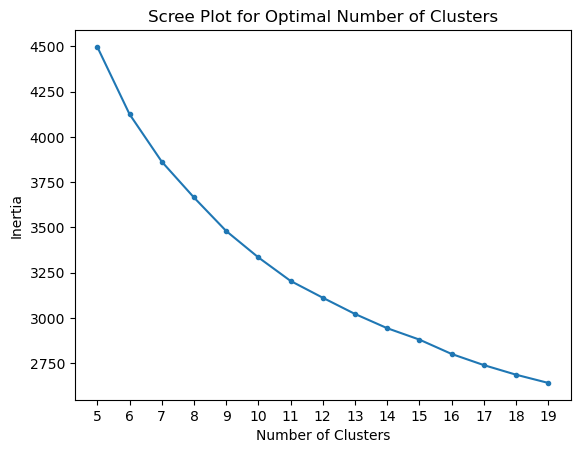

In [55]:
# Calculate the sum of squared distances (inertia) for different numbers of clusters

inertia_list = []
num_clusters = range(5, 20)

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(topic_prob_array)
    inertia_list.append(kmeans.inertia_)

# Draw the elbow plot (sum of squared distances vs. number of clusters)

plt.figure()
plt.plot(num_clusters, inertia_list, marker=".")
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Scree Plot for Optimal Number of Clusters')
plt.xticks(num_clusters)
plt.show()

The scree plot shows a very smooth curve without a clear "elbow" point. It can mean that the data may not have a distinct clustering structure or the structure might be more complex than what can be captured by `KMeans` alone. Again, choosing the optimal number of clusters is very challenging. We can try another approach, which is the Density-Based Spatial Clustering of Applications with Noise (DBSCAN).

## Topic Probability Analysis with DBSCAN

`DBSCAN` is based on the density of data points rather than their distances from cluster centroids. `DBSCAN` can identify noise points that don't belong to any cluster. We hope that this method might reveal patterns that `KMeans` is not able to capture.

In [56]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
topic_prob_array_scaled = scaler.fit_transform(topic_prob_array)

# Initialize the DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the model to the topic probabilities
dbscan.fit(topic_prob_array_scaled)

# Get the cluster labels
# Noise points are assigned the label -1
labels = dbscan.labels_

# Add the cluster labels to our dataframe
movies_40000_df['cluster'] = labels

# Check the result
print(movies_40000_df.head())

     imdb_id                        title               original_title  \
0  tt0114709                    Toy Story                    Toy Story   
1  tt0113497                      Jumanji                      Jumanji   
2  tt0113228             Grumpier Old Men             Grumpier Old Men   
3  tt0114885            Waiting to Exhale            Waiting to Exhale   
4  tt0113041  Father of the Bride Part II  Father of the Bride Part II   

                                            overview  \
0  Led by Woody, Andy's toys live happily in his ...   
1  When siblings Judy and Peter discover an encha...   
2  A family wedding reignites the ancient feud be...   
3  Cheated on, mistreated and stepped on, the wom...   
4  Just when George Banks has recovered from his ...   

                                      clean_overview  \
0  led woodi toy live happili room birthday bring...   
1  sibl discov enchant board game open door magic...   
2  famili wed reignit ancient feud next door neig.

We can visualize the results by creating a plot. Since your data is multidimensional (topic probabilities for 14 topics), we need to reduce the dimensionality to 2D before plotting. By using the t-SNE technique, we can create a 2D visualization.

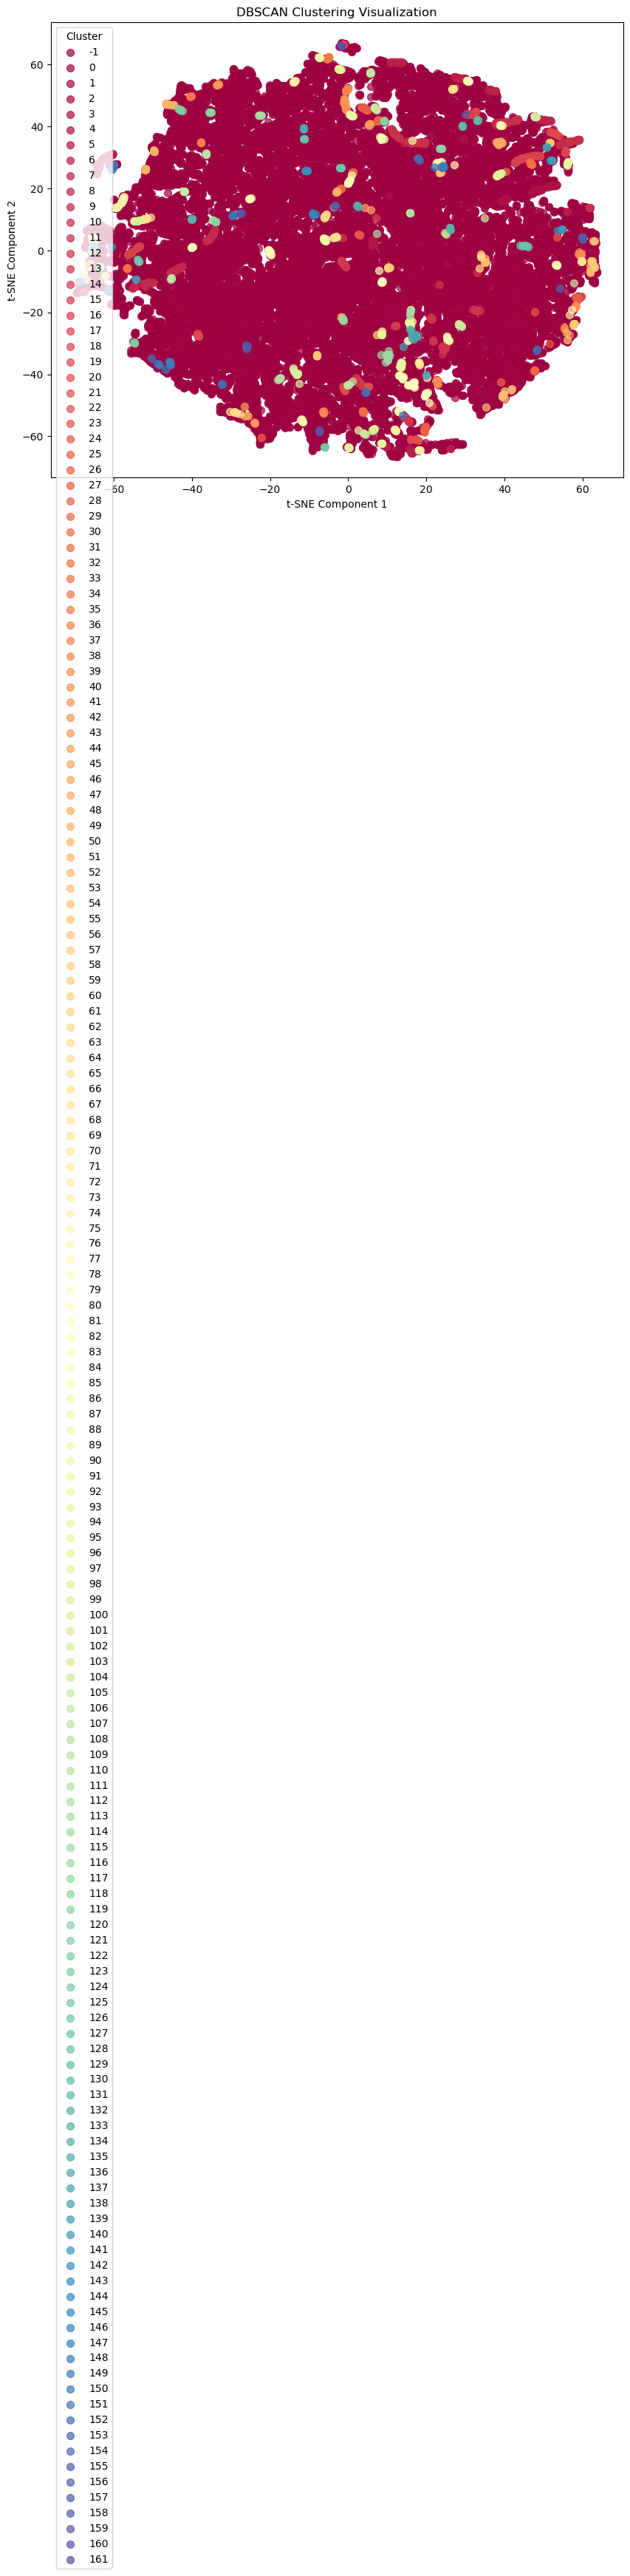

In [57]:
from sklearn.manifold import TSNE

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
topic_prob_array_2D = tsne.fit_transform(topic_prob_array)

# Create a scatter plot
plt.figure(figsize=(10, 8))
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for cluster_label, color in zip(unique_labels, colors):
    # Get the points belonging to the current cluster
    points = topic_prob_array_2D[labels == cluster_label]

    # Plot the points
    plt.scatter(points[:, 0], points[:, 1], s=50, c=[color], label=cluster_label, alpha=0.7)

# Set plot title and labels
plt.title('DBSCAN Clustering Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Add a legend
plt.legend(title='Cluster', loc='best')

# Show the plot
plt.show()

The clustering looks awful. We need to experiment with different values for `eps` and `min_samples` for sure.<br>To confirm that the current DBSCAN did not work well, we can calculate the silhouette score. It is a metric that measures the quality of clustering by calculating the average silhouette coefficient for each data point. The silhouette coefficient is a value between -1 and 1, where higher values indicate better clustering. We can use the silhouette score to compare different configurations of `eps` and `min_samples`. 

However, note that the silhouette score may not work well for DBSCAN when there are a lot of noise points, as it treats them as a separate cluster.

In [58]:
from sklearn.metrics import silhouette_score

# Compute the silhouette score (excluding noise points)
# Only include points with a label greater than -1 (noise points have a label of -1)
sil_score = silhouette_score(topic_prob_array_scaled[labels != -1], labels[labels != -1])

print("Silhouette score:", sil_score)

Silhouette score: -0.10805798


Silhouette score close to -1 indicates that poor clustering results, while a score close to 1 indicates well-separated clusters.

We can adjust our `eps` and `min_samples` and check the result again.
- `eps`: This parameter defines the maximum distance between two points for them to be considered as part of the same cluster. In other words, if the distance between two points is less than or equal to eps, they will be considered neighbors and potentially part of the same cluster.
- `min_samples`: This parameter specifies the minimum number of points that must be within the eps radius of a point for it to be considered a core point (i.e., a point that forms the basis of a cluster).

In [62]:
# Initialize the DBSCAN model with different values
dbscan2 = DBSCAN(eps=0.6, min_samples=10)

# Fit the model to the topic probabilities
dbscan2.fit(topic_prob_array_scaled)

# Get the cluster labels
# Noise points are assigned the label -1
labels = dbscan2.labels_

# Add the cluster labels to our dataframe
movies_40000_df['cluster'] = labels

# Compute the silhouette score (excluding noise points)
sil_score2 = silhouette_score(topic_prob_array_scaled[labels != -1], labels[labels != -1])

print("Silhouette score:", sil_score2)

Silhouette score: -0.22061114


The silhouette score became closer to -1, indicating that the clustering quality has further deteriorated.

In [60]:
# Initialize the DBSCAN model with different values
dbscan3 = DBSCAN(eps=0.4, min_samples=8)

# Fit the model to the topic probabilities
dbscan3.fit(topic_prob_array_scaled)

# Get the cluster labels
# Noise points are assigned the label -1
labels = dbscan3.labels_

# Add the cluster labels to our dataframe
movies_40000_df['cluster'] = labels

# Compute the silhouette score (excluding noise points)
sil_score3 = silhouette_score(topic_prob_array_scaled[labels != -1], labels[labels != -1])

print("Silhouette score:", sil_score3)

Silhouette score: 0.16929795


The silhouette score close to 0.17 indicates that the model is a bit improved.

In [65]:
# Initialize the DBSCAN model with different values
dbscan6 = DBSCAN(eps=0.2, min_samples=8)

# Fit the model to the topic probabilities
dbscan6.fit(topic_prob_array_scaled)

# Get the cluster labels
# Noise points are assigned the label -1
labels = dbscan6.labels_

# Add the cluster labels to our dataframe
movies_40000_df['cluster'] = labels

# Compute the silhouette score (excluding noise points)
sil_score6 = silhouette_score(topic_prob_array_scaled[labels != -1], labels[labels != -1])

print("Silhouette score:", sil_score6)

Silhouette score: 0.61682254


In [80]:
# Initialize the DBSCAN model with different values
dbscan12 = DBSCAN(eps=0.1, min_samples=15)

# Fit the model to the topic probabilities
dbscan12.fit(topic_prob_array_scaled)

# Get the cluster labels
# Noise points are assigned the label -1
labels = dbscan12.labels_

# Add the cluster labels to our dataframe
movies_40000_df['cluster'] = labels

# Compute the silhouette score (excluding noise points)
sil_score12 = silhouette_score(topic_prob_array_scaled[labels != -1], labels[labels != -1])

print("Silhouette score:", sil_score12)

Silhouette score: 0.87740934


The silhouette score of 0.878 is a significant improvement over the previous scores, indicating that the clustering quality has improved with the new `eps` and `min_samples`values.<br>The below table is the summary of our experiment with the two parameters and resulting silhouette scores.

| **eps** | **min_samples** | **silhouette score** |
|---------|-----------------|----------------------|
| 0.5     | 5               | -0.1080              |
| 0.6     | 10              | -0.2206              |
| 0.4     | 8               | 0.1692               |
| 0.3     | 8               | 0.4947               |
| 0.2     | 7               | 0.5977               |
| 0.2     | 8               | 0.6168               |
| 0.2     | 9               | 0.6285               |
| 0.2     | 10              | 0.6350               |
| 0.2     | 11              | 0.6906               |
| 0.2     | 12              | 0.7072               |
| 0.1     | 12              | 0.8258               |
| 0.1     | 15              | 0.8774               |
| 0.1     | 16              | 0.8774               |

Based on this iteration result, we can tentatively select `eps=0.1` and `min_samples=15` as optimal values.<Br>Based on the best clustering result, we can analyze the distribution of genres within each cluster.

In [82]:
# Group the movies by cluster label
cluster_groups = movies_40000_df.groupby('cluster')

# Loop over each cluster group and calculate the frequency of genres
for cluster_label, group in cluster_groups:
    genre_counts = group['genres'].str.get_dummies(',').sum()
    print(f"Cluster {cluster_label}:")
    print(genre_counts)
    print()

Cluster -1:
 'Action'        1387
 'Action']        538
 'Adventure'     1276
 'Adventure']     545
 'Animation'      546
                 ... 
['War'            313
['War']            35
['Western'        119
['Western']       299
[]               1961
Length: 81, dtype: int64

Cluster 0:
 'Action'        1
 'Action']       1
 'Comedy'        5
 'Comedy']       6
 'Crime'         1
 'Crime']        1
 'Drama'        15
 'Drama']       12
 'Family']       1
 'Fantasy']      2
 'Foreign']      3
 'Horror']       2
 'Romance'       5
 'Romance']     45
 'TV Movie']     2
 'Thriller'      3
 'Thriller']     7
 'War']          1
['Adventure'     2
['Animation'     1
['Comedy'       32
['Comedy']      19
['Crime'         1
['Drama'        36
['Drama']       25
['Family'        1
['Fantasy'       1
['Horror'        2
['Romance'       5
['Thriller'      2
['Thriller']     3
[]               8
dtype: int64

Cluster 1:
 'Action'               1
 'Adventure'            1
 'Animation']           

In [83]:
movies_40000_df['genres'] = movies_40000_df['genres'].apply(lambda x: list(set(x)))

In [84]:
# Group the movies by cluster label
cluster_groups = movies_40000_df.groupby('cluster')

# Loop over each cluster group and calculate the frequency of genres
for cluster_label, group in cluster_groups:
    genre_counts = group['genres'].str.get_dummies(',').sum()
    print(f"Cluster {cluster_label}:")
    print(genre_counts)
    print()

Cluster -1:
 'Action'         554
 'Action']       5172
 'Adventure'     2043
 'Adventure']     447
 'Comedy'         696
                 ... 
['War'            964
['War']            35
['Western'        172
['Western']       299
[]               1961
Length: 79, dtype: int64

Cluster 0:
 'Action'        1
 'Action']       1
 'Adventure'     1
 'Comedy'        1
 'Crime']        3
 'Drama'         5
 'Drama']       56
 'Family'        1
 'Fantasy'       1
 'Fantasy']      1
 'Foreign']      1
 'Horror']       3
 'Romance'      20
 'Romance']     15
 'TV Movie']     2
 'Thriller']     1
['Adventure'     1
['Animation'     1
['Comedy'       42
['Comedy']      19
['Drama'         2
['Drama']       25
['Family'        1
['Fantasy'       1
['Foreign'       2
['Horror'        1
['Romance'      20
['Thriller'     11
['Thriller']     3
['War'           1
[]               8
dtype: int64

Cluster 1:
 'Action']            10
 'Adventure'           1
 'Comedy'              1
 'Comedy']          

We've cleaned the `genres` column earlier in our first notebook. But the result doesn't look clean.<Br>We can clean the column again to remove unnecessary square quotes and then calculate the frequency of genres again.

In [91]:
# Define a function to clean
def clean_genres(genres):
    cleaned_genres = ', '.join(genres)
    return cleaned_genres

# Apply the cleaning function to the 'genres' column
movies_40000_df['clean_genres'] = movies_40000_df['genres'].apply(clean_genres)

# Group the movies by cluster label
cluster_groups = movies_40000_df.groupby('cluster')

# Loop over each cluster group and calculate the frequency of genres
for cluster_label, group in cluster_groups:
    genre_counts = group['clean_genres'].str.get_dummies(', ').sum()
    print(f"Cluster {cluster_label}:")
    print(genre_counts)
    print("----------------------------")

Cluster -1:
Action              6075
Adventure           3204
Animation           1818
Comedy             12005
Crime               3903
Documentary         3696
Drama              18203
Family              2551
Fantasy             2094
Foreign             1461
History             1285
Horror              4192
Music               1491
Mystery             2250
Romance             6087
Science Fiction     2809
TV Movie             658
Thriller            6798
War                 1227
Western              972
dtype: int64
----------------------------
Cluster 0:
Action        2
Adventure     2
Animation     1
Comedy       62
Crime         3
Drama        88
Family        2
Fantasy       3
Foreign       3
Horror        4
Romance      55
TV Movie      2
Thriller     15
War           1
dtype: int64
----------------------------
Cluster 1:
Action             10
Adventure           1
Animation           4
Comedy             62
Crime               4
Documentary         6
Drama              40
Fami

We have created clean lists of the frequency of genres in each cluster. In DBSCAN, cluster -1 represents outliers. These are the data points that do not belong to any cluster, as they do not satisfy the density requirements for forming a cluster. Unfortunately, the majority of movies belong to cluster -1. This can mean several things. 
- Firstly, we can argue that the parameter tuning process was not successful, despite the high silhouette score. 
- Secondly, and more convincingly, we can acknowledge that clustering movies solely based on their genres may not produce well-separated clusters, particularly if genres are not evenly distributed or if many movies have overlapping genres.

In theory, we can explore additional features or dimensions to capture the relationships between movies better.
However, given the time and resource constraints, we can stop here and move on to the next process.

In [94]:
# Check the dataframe at this point
movies_40000_df.head()

,imdb_id,title,original_title,overview,clean_overview,genres,tagline,poster_path,num_tokens,ada_embeddings,...,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,cluster,cluster_8,cluster_10,clean_genres
0,tt0114709,Toy Story,Toy Story,"Led by Woody, Andy's toys live happily in his ...",led woodi toy live happili room birthday bring...,"[Animation, Comedy, Family]",NaN,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,26,"[-0.01801527477800846, -0.02206587977707386, 0...",...,0.494523,0.327026,0.002668,0.052484,0.002668,0.002668,-1,5,4,"Animation, Comedy, Family"
1,tt0113497,Jumanji,Jumanji,When siblings Judy and Peter discover an encha...,sibl discov enchant board game open door magic...,"[Family, Adventure, Fantasy]",Roll the dice and unleash the excitement!,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,33,"[-0.005219690967351198, -0.019913190975785255,...",...,0.417726,0.002165,0.410232,0.002165,0.050003,0.002165,-1,2,8,"Family, Adventure, Fantasy"
2,tt0113228,Grumpier Old Men,Grumpier Old Men,A family wedding reignites the ancient feud be...,famili wed reignit ancient feud next door neig...,"[Comedy, Romance]",Still Yelling. Still Fighting. Still Ready for...,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,31,"[0.006672864779829979, -0.010083439759910107, ...",...,0.436004,0.435819,0.002236,0.002236,0.002236,0.002236,-1,5,4,"Comedy, Romance"
3,tt0114885,Waiting to Exhale,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",cheat mistreat step women hold breath wait elu...,"[Comedy, Romance, Drama]",Friends are the people who let you be yourself...,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,24,"[-0.016164006665349007, -0.0014150608330965042...",...,0.961296,0.002977,0.002977,0.002977,0.002977,0.002977,0,6,6,"Comedy, Romance, Drama"
4,tt0113041,Father of the Bride Part II,Father of the Bride Part II,Just when George Banks has recovered from his ...,recov daughter wed receiv news pregnant wife e...,[Comedy],Just When His World Is Back To Normal... He's ...,/e64sOI48hQXyru7naBFyssKFxVd.jpg,17,"[-0.012427903711795807, 0.0046121967025101185,...",...,0.179889,0.659369,0.003970,0.003970,0.117070,0.003970,-1,3,9,Comedy


In [95]:
# Save the current dataframe
#movies_40000_df.to_csv('ada_embeddings_movie_40000_with_14_topics_10_cluster.csv', index=False)

## Summary

In conclusion, our analysis demonstrated the iterative and exploratory nature of unsupervised machine learning techniques applied to movie data. Although the clustering results were not as clearly separated as we initially hoped, we experimented with various approaches, such as `LDA` for topic modeling, `k-means` clustering, and `DBSCAN`. 

Throughout this process, we encountered challenges in parameter tuning and discussed the limitations of clustering based solely on genres and latent topics.

Despite these challenges, we gained valuable insights into the dataset's structure and recognized the importance of incorporating additional features or dimensions to better capture the relationships between movies. This experience highlights the importance of trial and error and continuous improvement in data-driven analyses, ultimately enriching our understanding of complex data structures and fostering a positive approach to problem-solving in machine learning.

Now let's move onto our [**final notebook!**](https://github.com/treelunar/2023_Capstone_BSTN/blob/main/Part_4_Model_Selection.ipynb)

### Acknowledgement
- Some online articles were helpful in conductin LDA analysis, including ["Visualizing Unsupervised Text Classification Output with pyLDAvis"](https://medium.com/@nqabell89/visualizing-unsupervised-text-classification-output-with-pyldavis-370c1784ed58) by Nicholas Abell and ["Topic Modeling with Latent Dirichlet Allocations (LDA)"](https://medium.com/broadhorizon-cmotions/topic-modeling-with-latent-dirichlet-allocations-lda-ab7ed0eb6eac) by Konstantina Andronikou.